In [86]:
from pgmpy.models import BayesianModel

#defining the network structure 

model = BayesianModel([('Unforeseen Events','Produced Qty'),
                      ('Target Audience','Produced Qty'),
                      ('Target Audience','Price'),
                      ('Cost of Production','Price'),
                      ('High End Product','Price'),
                      ('Marketing','Popularity'),
                      ('Reputation','Popularity'),
                      ('Price','Sold Qty'),
                      ('Popularity','Sold Qty'),
                      ('Produced Qty','Availability'),
                      ('Sold Qty','Availability'),
                      ('Popularity','Domino Effect'),
                      ('Availability','Domino Effect')])

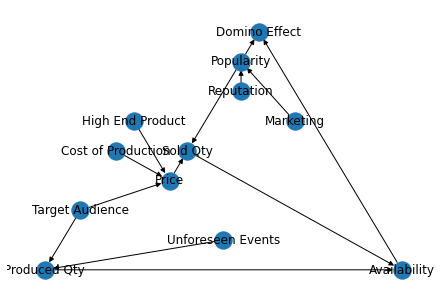

In [87]:
#show the topology of the network (for a better visualization look in the report)

import matplotlib.pylab as plt
import networkx as nx

nx.draw_planar(model,with_labels=True)

plt.show()

In [88]:
# Defining the CPDs:
from pgmpy.factors.discrete import TabularCPD

u_cpd=TabularCPD('Unforeseen Events',2,[[.1],[.9]],state_names={'Unforeseen Events': ['Yes', 'No']})
t_a_cpd=TabularCPD('Target Audience',2,[[.7],[.3]],state_names={'Target Audience':['Mass','Niche']})
c_p_cpd=TabularCPD('Cost of Production',2,[[.5],[.5]],state_names={'Cost of Production': ['Low', 'High']})
h_e_cpd=TabularCPD('High End Product',2,[[.35],[.65]],state_names={'High End Product': ['Yes', 'No']})
p_cpd=TabularCPD('Price',2,[[.4,.9,.15,.6,.3,.45,.05,.25],[.6,.1,.85,.4,.7,.55,.95,.75]],evidence=['Target Audience','Cost of Production','High End Product'],evidence_card=[2,2,2],
                 state_names={'Price': ['Low','High'],'Target Audience':['Mass','Niche'],'Cost of Production':['Low','High'],'High End Product':['Yes','No']})
m_cpd=TabularCPD('Marketing',3,[[.2],[.7],[.1]],state_names={'Marketing': ['Null', 'Low','High']})
r_cpd=TabularCPD('Reputation',2,[[.5],[.5]],state_names={'Reputation': ['Normal', 'High']})
po_cpd=TabularCPD('Popularity',3,[[.95,.6,.75,.5,.20,.05],[.04,.35,.24,.4,.45,.2],[.01,.05,.01,.1,.35,.75]],evidence=['Marketing','Reputation'],evidence_card=[3,2],
                 state_names={'Popularity': ['Null','High','Very High'],'Marketing':['Null','Low','High'],'Reputation':['Normal','High']})
s_q_cpd=TabularCPD('Sold Qty',3,[[.35,.02,.01,.75,.15,.03],[.6,.48,.14,.23,.5,.2],[.05,.5,.85,.02,.35,.77]],evidence=['Price','Popularity'],evidence_card=[2,3],
                  state_names={'Sold Qty': ['Low', 'Medium','High'],'Price':['Low','High'],'Popularity':['Null','High','Very High']})
p_q_cpd=TabularCPD('Produced Qty',3,[[.7,.9,.01,.6],[.25,.09,.08,.37],[.05,.01,.91,.03]],evidence=['Unforeseen Events','Target Audience'],evidence_card=[2,2],
                  state_names={'Produced Qty': ['Low','Medium','High'],'Unforeseen Events': ['Yes', 'No'],'Target Audience':['Mass','Niche']})
a_cpd=TabularCPD('Availability',3,[[.1,.6,.94,.01,.2,.8,.01,.02,.29],[.85,.38,.05,.3,.75,.19,.07,.25,.7],[.05,.02,.01,.69,.05,.01,.92,.73,.01]],evidence=['Produced Qty','Sold Qty'],evidence_card=[3,3],
                state_names={'Availability': ['Out of stock','Keep up with demand','Surplus'],'Produced Qty': ['Low','Medium','High'],'Sold Qty': ['Low', 'Medium','High']})
d_e_cpd=TabularCPD('Domino Effect',2,[[.5,.15,.01,.8,.55,.15,.97,.7,.2],[.5,.85,.99,.2,.45,.85,.03,.3,.8]],evidence=['Popularity','Availability'],evidence_card=[3,3],
                  state_names={'Domino Effect':['Yes','No'],'Popularity': ['Null','High','Very High'],'Availability': ['Out of stock','Keep up with demand','Surplus']})

#add them to the model 
model.add_cpds(u_cpd,t_a_cpd,c_p_cpd,h_e_cpd,p_cpd,m_cpd,r_cpd,po_cpd,s_q_cpd,p_q_cpd,a_cpd,d_e_cpd)

#check if the model is correctly defined 
#checks if the sum of the probabilities for each state is equal to 1 
if model.check_model():
    print('correcty defined model')


correcty defined model


In [89]:
#uncomment this if you want some or all the CPT to be printed
#visualization for big CPTs is not really preatty, you will need a large screen to correctly visualize them 

# print(u_cpd)         #unforeseen events
# print(t_a_cpd)       #target audience
# print(c_p_cpd)       #cost of production
# print(h_e_cpd)       #high end product
# print(p_cpd)         #price
# print(m_cpd)         #marketing
# print(r_cpd)         #reputation
# print(po_cpd)        #popularity
# print(s_q_cpd)       #sold qty
#print(p_q_cpd)        #produced qty
#print(a_cpd)          #availability
#print(d_e_cpd)        #domino effect

In [90]:
#local independencies 

print(model.local_independencies('Produced Qty'))
print(model.local_independencies('Availability'))

(Produced Qty ⟂ Sold Qty, High End Product, Price, Reputation, Popularity, Cost of Production, Marketing | Unforeseen Events, Target Audience)
(Availability ⟂ High End Product, Unforeseen Events, Popularity, Price, Reputation, Target Audience, Cost of Production, Marketing | Sold Qty, Produced Qty)


In [91]:
#markov blanket 

model.get_markov_blanket('Sold Qty')

['Produced Qty', 'Availability', 'Popularity', 'Price']

In [92]:
#check d-separation 

print(model.is_active_trail('Marketing','Availability'))
print(model.is_active_trail('Marketing','Availability',observed=['Popularity']))

True
False


In [93]:
print(model.is_active_trail('Cost of Production','High End Product'))
print(model.is_active_trail('Cost of Production','High End Product',observed=['Price']))

False
True


In [94]:
#print all nodes in an active trail from Price 

print(model.active_trail_nodes('Price'))

{'Price': {'High End Product', 'Produced Qty', 'Availability', 'Domino Effect', 'Sold Qty', 'Price', 'Target Audience', 'Cost of Production'}}


In [95]:
#method for exact inference 

from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(model)

In [96]:
print('P(Availability|Produced Qty = Low, Marketing = High, Price = Low)')
query1 = exact_inference.query(['Availability'],{'Produced Qty':'Low','Marketing':'High','Price':'Low'},show_progress=False)
print(query1)

P(Availability|Produced Qty = Low, Marketing = High, Price = Low)
+-----------------------------------+---------------------+
| Availability                      |   phi(Availability) |
+===================================+=====================+
| Availability(Out of stock)        |              0.7884 |
+-----------------------------------+---------------------+
| Availability(Keep up with demand) |              0.1962 |
+-----------------------------------+---------------------+
| Availability(Surplus)             |              0.0153 |
+-----------------------------------+---------------------+


In [97]:
query2 = exact_inference.query(['Sold Qty'],{'Marketing':'Low','Reputation':'Normal'},show_progress=False)
print('P(Sold Qty|Marketing = Low, Reputation = Normal)')
print(query2)
query3 = exact_inference.query(['Sold Qty'],{'Marketing':'High','Reputation':'Normal'},show_progress=False)
print('P(Sold Qty|Marketing = High, Reputation = Normal)')
print(query3)

P(Sold Qty|Marketing = Low, Reputation = Normal)
+------------------+-----------------+
| Sold Qty         |   phi(Sold Qty) |
+==================+=================+
| Sold Qty(Low)    |          0.4347 |
+------------------+-----------------+
| Sold Qty(Medium) |          0.4293 |
+------------------+-----------------+
| Sold Qty(High)   |          0.1361 |
+------------------+-----------------+
P(Sold Qty|Marketing = High, Reputation = Normal)
+------------------+-----------------+
| Sold Qty         |   phi(Sold Qty) |
+==================+=================+
| Sold Qty(Low)    |          0.1559 |
+------------------+-----------------+
| Sold Qty(Medium) |          0.3628 |
+------------------+-----------------+
| Sold Qty(High)   |          0.4813 |
+------------------+-----------------+


In [98]:
print('P(Price| Availability = Surplus, Target Audience = Niche)')
query4 = exact_inference.query(['Price'],{'Availability':'Surplus','Target Audience':'Niche'},show_progress=False)
print(query4)

P(Price| Availability = Surplus, Target Audience = Niche)
+-------------+--------------+
| Price       |   phi(Price) |
+=============+==============+
| Price(Low)  |       0.1865 |
+-------------+--------------+
| Price(High) |       0.8135 |
+-------------+--------------+


In [99]:
# print most likely explanation for (Price = High, Availability = Out of stock, Produced Qty = High)
query5 = exact_inference.map_query(['Reputation'],{'Price':'High','Availability':'Out of stock','Produced Qty':'High'},show_progress=False)
print(query5)

{'Reputation': 'High'}


In [100]:
query6 = exact_inference.query(['Availability'],{'Target Audience':'Mass'},show_progress=False)
print('P(Availability| Target Audience = Mass)')
print(query6)
query7 = exact_inference.query(['Availability'],{'Target Audience':'Mass','Unforeseen Events':'Yes'},show_progress=False)
print('P(Availability| Target Audience = Mass, Unforeseen Events = Yes)')
print(query7)

P(Availability| Target Audience = Mass)
+-----------------------------------+---------------------+
| Availability                      |   phi(Availability) |
+===================================+=====================+
| Availability(Out of stock)        |              0.1328 |
+-----------------------------------+---------------------+
| Availability(Keep up with demand) |              0.3245 |
+-----------------------------------+---------------------+
| Availability(Surplus)             |              0.5428 |
+-----------------------------------+---------------------+
P(Availability| Target Audience = Mass, Unforeseen Events = Yes)
+-----------------------------------+---------------------+
| Availability                      |   phi(Availability) |
+===================================+=====================+
| Availability(Out of stock)        |              0.4308 |
+-----------------------------------+---------------------+
| Availability(Keep up with demand) |              0.45

In [101]:
#compare exact and approximate inference 

import numpy as np
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

BMS = BayesianModelSampling(model)    

def LW_prob(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),3)

def get_sample_inference(sample_size):
    
    samples_LW = BMS.likelihood_weighted_sample(evidence = evidence, size=sample_size, return_type='recarray')     #Weighted Likelihood as sampling method
    result_LW = LW_prob(samples_LW,'Domino Effect')
    return result_LW

evidence = [State('Marketing','High'), State('Produced Qty','Low')]        #evidence for the query

query = exact_inference.query(['Domino Effect'], {'Marketing' : 'High','Produced Qty': 'Low'},show_progress=False)     #performing exact inference for comparison 
reference_prob = query.values[1]

starting_size = 2  # from 100 sample points
final_size = 5     # to 10^5 sample points
experiments = 10   # 10 experiments

#run 10 experiments with different sample size and store the results in a dictionary 
results = {}
for size in np.logspace(starting_size , final_size, num=experiments,dtype='<i8'):
    results[size] = get_sample_inference(size)

print('reference probability:',round(reference_prob,3),'\n')   

print ("{:<15} {:<8}".format('sample size','prob'))
for k, v in results.items():
    print ("{:<15} {:<8}".format(k, v))

/opt/conda/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"


reference probability: 0.227 

sample size     prob    
100             0.283   
215             0.286   
464             0.258   
1000            0.235   
2154            0.214   
4641            0.203   
10000           0.235   
21544           0.226   
46415           0.223   
100000          0.229   
